# Somite Segmentation - Exploratory Analysis

## Overview

This notebook explores somite segmentation using classical watershed methods. **Important**: This is exploratory work documenting that classical methods are insufficient for reliable somite segmentation without specific fluorescent markers.

## What This Notebook Does

1. **Tissue Detection**: Identifies embryo tissue from background using CH1 + CH2
2. **PSM Exclusion**: Uses existing PSM masks to exclude the presomitic mesoderm region
3. **Boundary Detection**: Extracts membrane boundaries from Channel 2 (Sobel edges)
4. **Watershed Segmentation**: Applies 3D watershed to detect compartment-like regions
5. **Volume Filtering**: Filters detected regions by size

## Method Summary

| Step | Input | Output |
|------|-------|--------|
| Tissue Mask | CH1 + CH2 | Binary tissue region |
| Search Region | Tissue - PSM | Somite search area |
| Boundaries | CH2 Sobel edges | Membrane edges |
| Seeds | Distance transform peaks | Watershed seeds |
| Segmentation | Watershed on edges | Labeled compartments |

## Key Parameters (Configurable)

| Parameter | Default | Description |
|-----------|---------|-------------|
| `FACTOR_XY` | 0.25 | XY downsampling factor |
| `EDGE_PERCENTILE` | 85 | Threshold for edge detection |
| `MIN_DISTANCE_PEAKS` | 14 | Minimum distance between seeds |
| `MIN_SOMITE_VOLUME` | 400 | Minimum region volume (voxels) |
| `MAX_SOMITE_VOLUME` | 60000 | Maximum region volume (voxels) |
| `PSM_DILATION_ITERS` | 8 | PSM exclusion zone expansion |

## Limitations Documented

- Detected 5-10 fragmented regions per frame (expected: 1-2 somites)
- No temporal consistency between frames
- Results vary significantly with parameter tuning
- **Conclusion**: Reliable somite segmentation requires either specific fluorescent markers or supervised deep learning

## How to Use

1. **Ensure PSM masks exist**: Requires `mask_santi/` folder with CH3 masks
2. **Set test frames**: Modify `TEST_TIMEPOINTS_FIXED` list
3. **Run all cells**: Will process selected frames
4. **Review outputs**: Check `somite_v5_outputs/` for visualizations

## Output

- Debug visualizations: `somite_v5_outputs/somite_v5_debug_tXXXX.png`
- Binary masks: `somite_v5_outputs/somite_mask_small_tXXXX.tif`
- Summary plots: `somite_v5_outputs/somite_v5_summary.png`


In [1]:
# Cell 1: IMPORTS
import os
import re
import glob
import json
from time import time

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

from skimage.transform import rescale
from skimage.filters import gaussian, sobel
from skimage.morphology import (
    binary_closing,
    remove_small_objects,
    label as cc_label,
    binary_dilation,
)
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from scipy.ndimage import distance_transform_edt, binary_fill_holes

np.random.seed(42)
print("[OK] Imports loaded")


[OK] Imports loaded


In [2]:
# Cell 2: CONFIGURATION

BASE_DIR = "."
OUTPUT_DIR = "somite_v5_outputs"

# Processing mode
TEST_MODE = True
N_TEST = 4
TEST_FRAME_STRATEGY = "fixed"  # "uniform" or "fixed"
TEST_TIMEPOINTS_FIXED = [50, 100, 150, 200]

# Speed / memory
FACTOR_XY = 0.25

# Tissue mask parameters
TISSUE_THRESHOLD = 0.03
TISSUE_MIN_SIZE = 5000
TISSUE_CLOSING_ITERS = 5

# PSM exclusion
PSM_DILATION_ITERS = 8

# ROI cropping around PSM (in downsampled pixels)
ROI_PAD_YX = 120
ROI_MIN_SIZE_YX = 192

# Membrane boundary detection (Ch2)
CH2_SMOOTH_SIGMA = 2.0
EDGE_PERCENTILE = 85
BOUNDARY_DILATION_ITERS = 1

# Seed detection
MIN_DISTANCE_PEAKS = 14
PEAK_THRESHOLD_ABS = 2.0
MAX_PEAKS = 60

# Watershed / filtering
MIN_SOMITE_VOLUME = 400
MAX_SOMITE_VOLUME = 60000

# Saving
SAVE_DEBUG_PNG = True
SAVE_LABEL_TIF = False
SAVE_BINARY_TIF = True

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("[OK] Configuration loaded")
print(f"     TEST_MODE={TEST_MODE}, TEST_TIMEPOINTS={TEST_TIMEPOINTS_FIXED}")
print(f"     Downsample FACTOR_XY={FACTOR_XY}")
print(f"     Output dir: {OUTPUT_DIR}")


[OK] Configuration loaded
     TEST_MODE=True, TEST_TIMEPOINTS=[50, 100, 150, 200]
     Downsample FACTOR_XY=0.25
     Output dir: somite_v5_outputs


In [3]:
# Cell 3: DATASET + UTILS

def extract_t_index(path: str) -> int | None:
    """Extract timepoint number from filename like 't0123_Channel 1.tif'."""
    m = re.search(r"t(\d{4})", os.path.basename(path))
    return int(m.group(1)) if m else None


def build_dataset(base_dir: str = "."):
    """Build list of (t, ch1_path, ch2_path, psm_path) tuples."""
    os.chdir(base_dir)

    ch1 = glob.glob("t*_Channel 1.tif")
    ch2 = glob.glob("t*_Channel 2.tif")
    psm = glob.glob(os.path.join("mask_santi", "mask_t*_Channel 3.tif"))

    ch1_by_t = {extract_t_index(f): f for f in ch1}
    ch2_by_t = {extract_t_index(f): f for f in ch2}
    psm_by_t = {extract_t_index(f): f for f in psm}

    common = sorted(set(ch1_by_t) & set(ch2_by_t) & set(psm_by_t))
    dataset = [(t, ch1_by_t[t], ch2_by_t[t], psm_by_t[t]) for t in common]

    print(f"[OK] Found {len(dataset)} complete timepoints")
    return dataset


def downsample_volume(vol: np.ndarray, is_mask: bool = False) -> np.ndarray:
    """Downsample 3D volume in XY for speed."""
    order = 0 if is_mask else 1
    out = rescale(
        vol.astype(np.float32),
        scale=(1.0, FACTOR_XY, FACTOR_XY),
        order=order,
        preserve_range=True,
        anti_aliasing=not is_mask,
    ).astype(np.float32)
    return out


def normalize_robust(vol: np.ndarray) -> np.ndarray:
    """Robust percentile normalization to [0, 1]."""
    v = vol.astype(np.float32)
    v_nz = v[v > 0]
    if v_nz.size < 100:
        lo, hi = np.percentile(v, [1.0, 99.5])
    else:
        lo, hi = np.percentile(v_nz, [1.0, 99.5])
    return np.clip((v - lo) / (hi - lo + 1e-6), 0, 1)


def binary_dilation_iters(mask: np.ndarray, iters: int) -> np.ndarray:
    """Binary dilation using a safe loop (avoids version-specific API changes)."""
    out = mask.astype(bool)
    for _ in range(int(iters)):
        out = binary_dilation(out)
    return out


def keep_largest_component(mask: np.ndarray) -> np.ndarray:
    """Keep the largest connected component in a binary mask."""
    lab = cc_label(mask)
    if lab.max() == 0:
        return mask.astype(bool)
    counts = np.bincount(lab.ravel())
    counts[0] = 0
    largest = int(np.argmax(counts))
    return (lab == largest)


def compute_bbox_2d(mask2d: np.ndarray, pad: int, min_size: int, shape_yx: tuple[int, int]):
    """Compute a padded bounding box around a 2D mask."""
    ys, xs = np.where(mask2d)
    h, w = shape_yx
    if ys.size == 0:
        return (slice(0, h), slice(0, w))

    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())

    cy = (y0 + y1) // 2
    cx = (x0 + x1) // 2

    box_h = max((y1 - y0 + 1) + 2 * pad, min_size)
    box_w = max((x1 - x0 + 1) + 2 * pad, min_size)

    y0 = max(0, cy - box_h // 2)
    y1 = min(h, y0 + box_h)
    x0 = max(0, cx - box_w // 2)
    x1 = min(w, x0 + box_w)

    # Re-adjust if we hit borders
    y0 = max(0, y1 - box_h)
    x0 = max(0, x1 - box_w)

    return (slice(y0, y1), slice(x0, x1))


def mip(vol: np.ndarray) -> np.ndarray:
    """Maximum intensity projection along Z."""
    return vol.max(axis=0)


def best_z_by_tissue(tissue: np.ndarray) -> int:
    """Choose a display Z slice as the slice with maximum tissue area."""
    areas = tissue.reshape(tissue.shape[0], -1).sum(axis=1)
    return int(np.argmax(areas))


print("[OK] Utilities ready")


[OK] Utilities ready


In [4]:
# Cell 4: CORE SEGMENTATION (v5)

def get_tissue_mask(ch1: np.ndarray, ch2: np.ndarray) -> np.ndarray:
    """Compute a 3D tissue mask and keep the largest connected component."""
    combined = np.maximum(ch1, ch2)
    tissue = combined > TISSUE_THRESHOLD

    for _ in range(int(TISSUE_CLOSING_ITERS)):
        tissue = binary_closing(tissue)

    # Fill holes per slice (more robust than 3D fill)
    for z in range(tissue.shape[0]):
        tissue[z] = binary_fill_holes(tissue[z])

    tissue = remove_small_objects(tissue, min_size=int(TISSUE_MIN_SIZE))
    tissue = keep_largest_component(tissue)
    return tissue.astype(bool)


def segment_somites_v5(ch1: np.ndarray, ch2: np.ndarray, psm_mask: np.ndarray):
    """
    Segment somite-like compartments using Ch2 boundaries and a 3D watershed.

    Returns:
        labels_filt: int32 label volume (0=background)
        somite_mask: uint8 binary mask (labels_filt > 0)
        debug: dict with intermediate volumes (for visualization)
    """
    debug: dict[str, np.ndarray | float | int | tuple] = {}

    # 1) Tissue and search region (exclude PSM)
    tissue = get_tissue_mask(ch1, ch2)
    psm_bin = psm_mask.astype(bool)
    psm_dil = binary_dilation_iters(psm_bin, PSM_DILATION_ITERS)
    search = tissue & ~psm_dil

    debug["tissue"] = tissue
    debug["psm"] = psm_bin
    debug["psm_dil"] = psm_dil
    debug["search"] = search

    if search.sum() < 1000:
        labels0 = np.zeros_like(ch1, dtype=np.int32)
        return labels0, labels0.astype(np.uint8), debug

    # 2) Crop to ROI around PSM (2D bbox on MIP)
    psm_mip = mip(psm_bin.astype(np.uint8)) > 0
    if psm_mip.sum() == 0:
        psm_mip = mip(search.astype(np.uint8)) > 0

    ys, xs = psm_mip.shape
    yx_sl = compute_bbox_2d(psm_mip, pad=ROI_PAD_YX, min_size=ROI_MIN_SIZE_YX, shape_yx=(ys, xs))
    y_sl, x_sl = yx_sl

    ch1r = ch1[:, y_sl, x_sl]
    ch2r = ch2[:, y_sl, x_sl]
    searchr = search[:, y_sl, x_sl]

    debug["roi_yx"] = (y_sl.start, y_sl.stop, x_sl.start, x_sl.stop)

    # 3) Boundary detection from Ch2
    ch2_s = gaussian(ch2r, sigma=CH2_SMOOTH_SIGMA)
    edges = np.zeros_like(ch2_s, dtype=np.float32)
    for z in range(ch2_s.shape[0]):
        edges[z] = sobel(ch2_s[z])

    edge_vals = edges[searchr]
    if edge_vals.size < 100:
        labels0 = np.zeros_like(ch1, dtype=np.int32)
        return labels0, labels0.astype(np.uint8), debug

    edge_thr = float(np.percentile(edge_vals, EDGE_PERCENTILE))
    boundary = (edges > edge_thr) & searchr
    if BOUNDARY_DILATION_ITERS > 0:
        boundary = binary_dilation_iters(boundary, BOUNDARY_DILATION_ITERS)

    debug["edges"] = edges
    debug["edge_thr"] = edge_thr
    debug["boundary"] = boundary

    # 4) Interior mask and distance transform
    interior = searchr & ~boundary
    dist = distance_transform_edt(interior)

    debug["interior"] = interior
    debug["dist"] = dist

    if dist.max() < 2.0:
        labels0 = np.zeros_like(ch1, dtype=np.int32)
        return labels0, labels0.astype(np.uint8), debug

    # 5) Seeds (peaks)
    peaks = peak_local_max(
        dist,
        min_distance=int(MIN_DISTANCE_PEAKS),
        threshold_abs=float(PEAK_THRESHOLD_ABS),
        exclude_border=False,
        labels=interior.astype(np.uint8),
        num_peaks=int(MAX_PEAKS),
    )

    debug["n_peaks"] = int(len(peaks))

    if len(peaks) == 0:
        labels0 = np.zeros_like(ch1, dtype=np.int32)
        return labels0, labels0.astype(np.uint8), debug

    markers = np.zeros_like(dist, dtype=np.int32)
    for i, (z, y, x) in enumerate(peaks):
        markers[z, y, x] = i + 1

    # 6) Watershed using membrane edges as elevation
    labels = watershed(edges, markers, mask=searchr)

    # 7) Filter by size
    labels_f = np.zeros_like(labels, dtype=np.int32)
    out_id = 0

    # Fast size filtering via bincount
    counts = np.bincount(labels.ravel())
    for lab_id in range(1, labels.max() + 1):
        vol = int(counts[lab_id]) if lab_id < counts.size else 0
        if vol < MIN_SOMITE_VOLUME or vol > MAX_SOMITE_VOLUME:
            continue
        out_id += 1
        labels_f[labels == lab_id] = out_id

    # 8) Paste back into full frame
    labels_full = np.zeros_like(ch1, dtype=np.int32)
    labels_full[:, y_sl, x_sl] = labels_f

    somite_mask = (labels_full > 0).astype(np.uint8)

    debug["n_labels"] = int(out_id)
    return labels_full, somite_mask, debug


print("[OK] v5 segmentation function ready")


[OK] v5 segmentation function ready


In [5]:
# Cell 5: LOAD DATA AND SELECT FRAMES

dataset = build_dataset(BASE_DIR)

if TEST_FRAME_STRATEGY == "fixed":
    test_frames = [x for x in dataset if x[0] in set(TEST_TIMEPOINTS_FIXED)]
else:
    idxs = np.linspace(0, len(dataset) - 1, N_TEST, dtype=int)
    test_frames = [dataset[i] for i in idxs]

print(f"[OK] Selected {len(test_frames)} frames")
print("     " + ", ".join([f"t={t:04d}" for t, *_ in test_frames]))


[OK] Found 218 complete timepoints
[OK] Selected 4 frames
     t=0050, t=0100, t=0150, t=0200


In [6]:
# Cell 6: RUN SEGMENTATION (TEST MODE)

def save_debug_figure(t: int, ch1: np.ndarray, ch2: np.ndarray, psm: np.ndarray, somite: np.ndarray, debug: dict):
    """Save a MIP-based debug panel as PNG."""
    ch1_m = mip(ch1)
    ch2_m = mip(ch2)
    psm_m = mip(psm.astype(np.uint8))
    som_m = mip(somite.astype(np.uint8))

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(ch1_m, cmap="gray")
    axes[0].set_title("Ch1 MIP (nuclei)")

    axes[1].imshow(ch2_m, cmap="gray")
    axes[1].set_title("Ch2 MIP (membranes)")

    overlay = np.zeros((*ch1_m.shape, 3), dtype=np.float32)
    overlay[..., 0] = psm_m.astype(np.float32)
    overlay[..., 1] = som_m.astype(np.float32)
    overlay[..., 2] = som_m.astype(np.float32)
    axes[2].imshow(np.clip(overlay, 0, 1))
    axes[2].set_title("Overlay (PSM=red, Somites=cyan)")

    # Show ROI on MIP (optional)
    axes[3].imshow(som_m, cmap="gray")
    axes[3].set_title("Somite mask MIP")

    for ax in axes:
        ax.axis("off")

    fig.suptitle(f"t={t:04d} | labels={debug.get('n_labels', 0)} | peaks={debug.get('n_peaks', 0)}", fontsize=12)
    out_path = os.path.join(OUTPUT_DIR, f"somite_v5_debug_t{t:04d}.png")
    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.close(fig)


results = []

print("=" * 70)
print("RUNNING SOMITE SEGMENTATION v5")
print("=" * 70)

for i, (t, p1, p2, p_psm) in enumerate(test_frames):
    print(f"[{i+1}/{len(test_frames)}] t={t:04d} ...", end=" ")
    t0 = time()

    # Load
    ch1_raw = tiff.imread(p1)
    ch2_raw = tiff.imread(p2)
    psm_raw = tiff.imread(p_psm)

    # Downsample + normalize
    ch1 = normalize_robust(downsample_volume(ch1_raw))
    ch2 = normalize_robust(downsample_volume(ch2_raw))
    psm = (downsample_volume(psm_raw, is_mask=True) > 0.5)

    labels, som_mask, debug = segment_somites_v5(ch1, ch2, psm)

    elapsed = time() - t0

    n_labels = int(debug.get("n_labels", 0))
    n_peaks = int(debug.get("n_peaks", 0))
    som_vol = int(som_mask.sum())
    psm_vol = int(psm.sum())

    results.append(
        {
            "t": t,
            "labels": labels,
            "som_mask": som_mask,
            "psm": psm,
            "ch1": ch1,
            "ch2": ch2,
            "debug": debug,
            "time": float(elapsed),
            "som_vol": som_vol,
            "psm_vol": psm_vol,
            "n_labels": n_labels,
            "n_peaks": n_peaks,
        }
    )

    print(f"[OK] labels={n_labels} peaks={n_peaks} som_vol={som_vol:,} psm_vol={psm_vol:,} [{elapsed:.1f}s]")

    if SAVE_DEBUG_PNG:
        save_debug_figure(t, ch1, ch2, psm, som_mask, debug)

    if SAVE_BINARY_TIF:
        out_tif = os.path.join(OUTPUT_DIR, f"somite_mask_small_t{t:04d}.tif")
        tiff.imwrite(out_tif, (som_mask * 255).astype(np.uint8))

    if SAVE_LABEL_TIF:
        out_tif = os.path.join(OUTPUT_DIR, f"somite_labels_small_t{t:04d}.tif")
        tiff.imwrite(out_tif, labels.astype(np.int32))

print("=" * 70)
print("DONE")
print("=" * 70)


RUNNING SOMITE SEGMENTATION v5
[1/4] t=0050 ... [OK] labels=8 peaks=60 som_vol=97,668 psm_vol=843,714 [88.3s]
[2/4] t=0100 ... [OK] labels=5 peaks=60 som_vol=25,247 psm_vol=607,722 [84.0s]
[3/4] t=0150 ... [OK] labels=10 peaks=60 som_vol=308,036 psm_vol=630,498 [85.8s]
[4/4] t=0200 ... [OK] labels=9 peaks=30 som_vol=112,499 psm_vol=421,209 [76.0s]
DONE


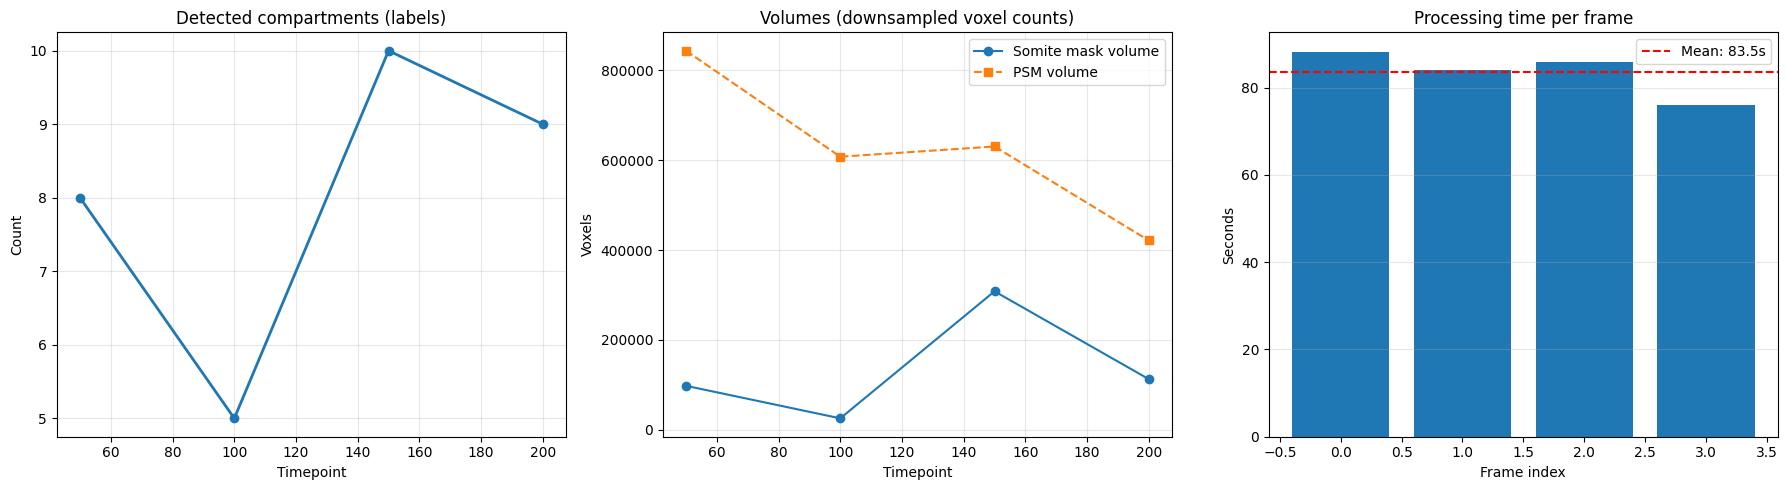


DETAILED SUMMARY
Timepoint  Labels   Peaks    SomVol       PSMVol       Time(s) 
----------------------------------------------------------------------
t=0050    8        60       97668        843714       88.3    
t=0100    5        60       25247        607722       84.0    
t=0150    10       60       308036       630498       85.8    
t=0200    9        30       112499       421209       76.0    


In [7]:
# Cell 7: SUMMARY PLOTS

if len(results) == 0:
    raise RuntimeError("No results computed. Check data paths and test frame selection.")

t_vals = [r["t"] for r in results]
labels_vals = [r["n_labels"] for r in results]
peaks_vals = [r["n_peaks"] for r in results]
times = [r["time"] for r in results]
som_vols = [r["som_vol"] for r in results]
psm_vols = [r["psm_vol"] for r in results]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: label count over time
axes[0].plot(t_vals, labels_vals, "o-", linewidth=2)
axes[0].set_title("Detected compartments (labels)")
axes[0].set_xlabel("Timepoint")
axes[0].set_ylabel("Count")
axes[0].grid(True, alpha=0.3)

# Plot 2: somite vs PSM volume
axes[1].plot(t_vals, som_vols, "o-", label="Somite mask volume")
axes[1].plot(t_vals, psm_vols, "s--", label="PSM volume")
axes[1].set_title("Volumes (downsampled voxel counts)")
axes[1].set_xlabel("Timepoint")
axes[1].set_ylabel("Voxels")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: runtime
axes[2].bar(range(len(times)), times)
axes[2].axhline(np.mean(times), color="red", linestyle="--", label=f"Mean: {np.mean(times):.1f}s")
axes[2].set_title("Processing time per frame")
axes[2].set_xlabel("Frame index")
axes[2].set_ylabel("Seconds")
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "somite_v5_summary.png"), dpi=150)
plt.show()

print("\n" + "=" * 70)
print("DETAILED SUMMARY")
print("=" * 70)
print(f"{'Timepoint':<10} {'Labels':<8} {'Peaks':<8} {'SomVol':<12} {'PSMVol':<12} {'Time(s)':<8}")
print("-" * 70)
for r in results:
    print(
        f"t={r['t']:04d}    {r['n_labels']:<8d} {r['n_peaks']:<8d} {r['som_vol']:<12d} {r['psm_vol']:<12d} {r['time']:<8.1f}"
    )
print("=" * 70)


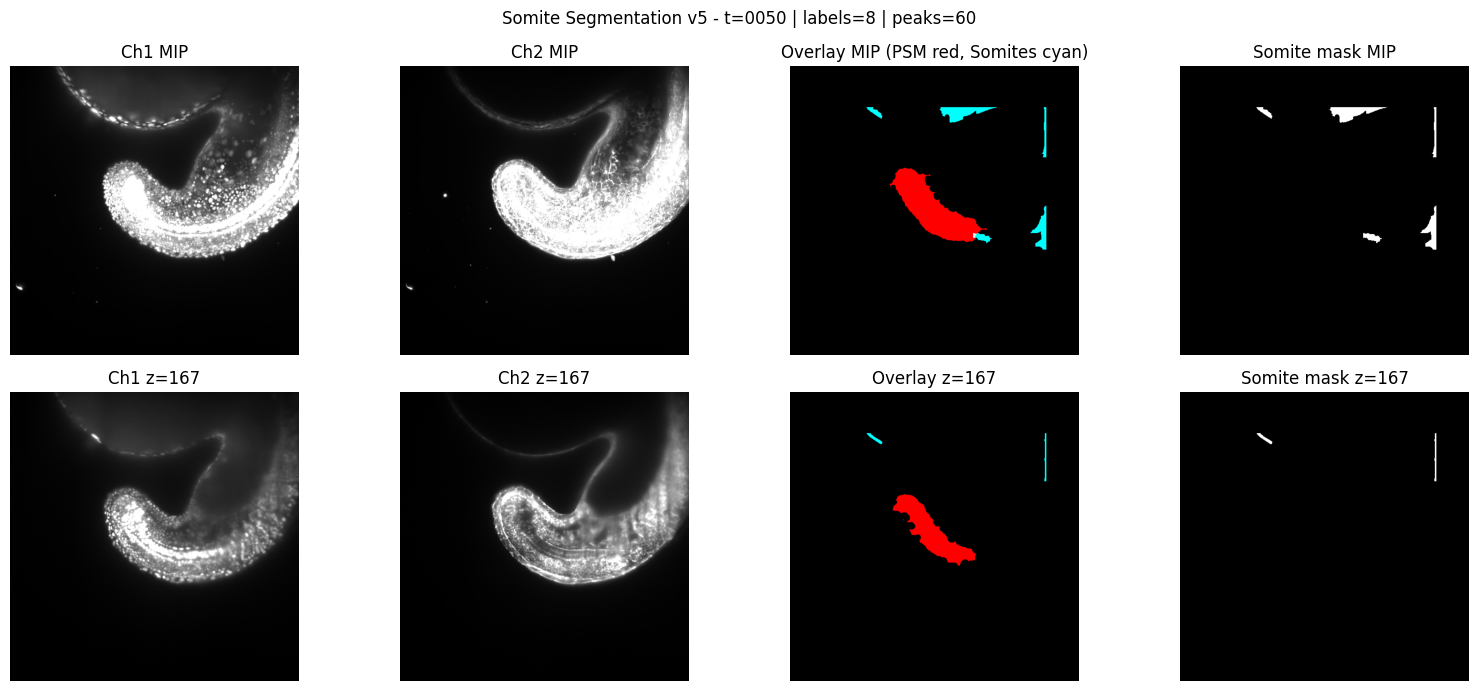

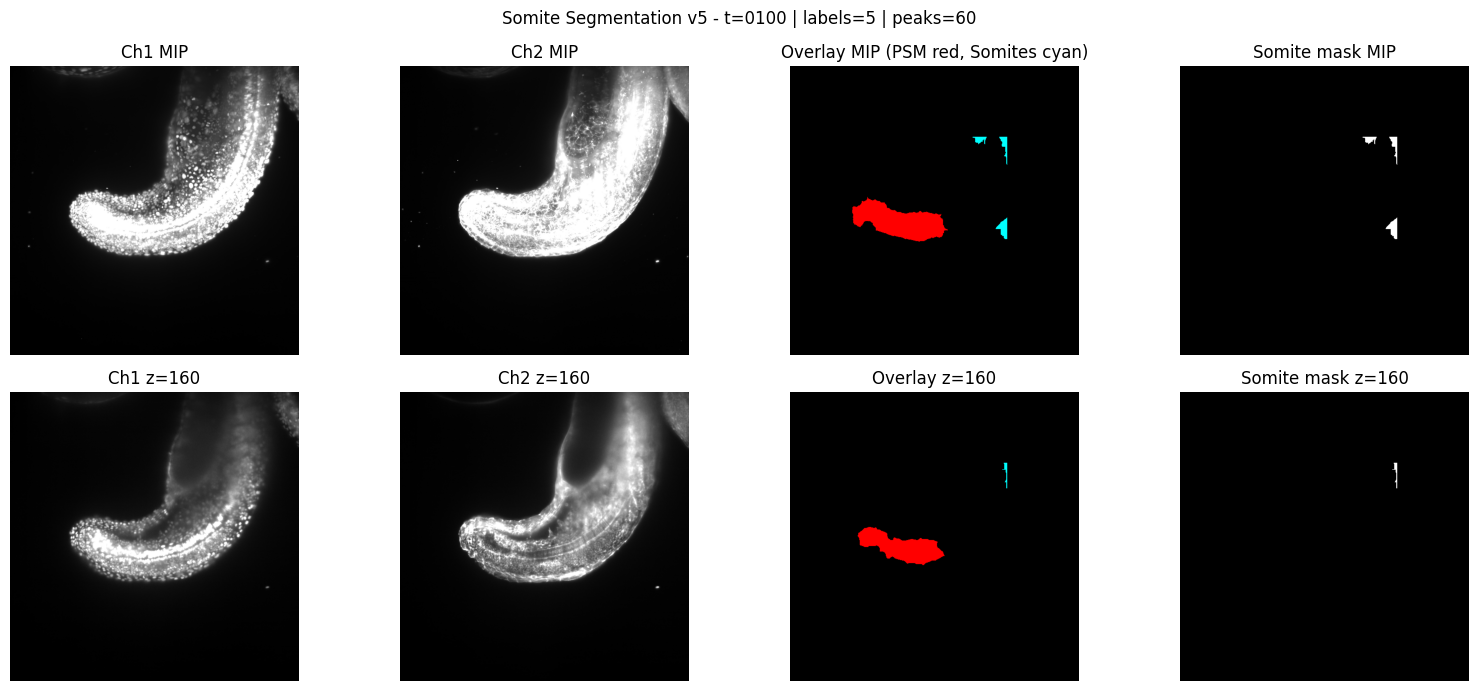

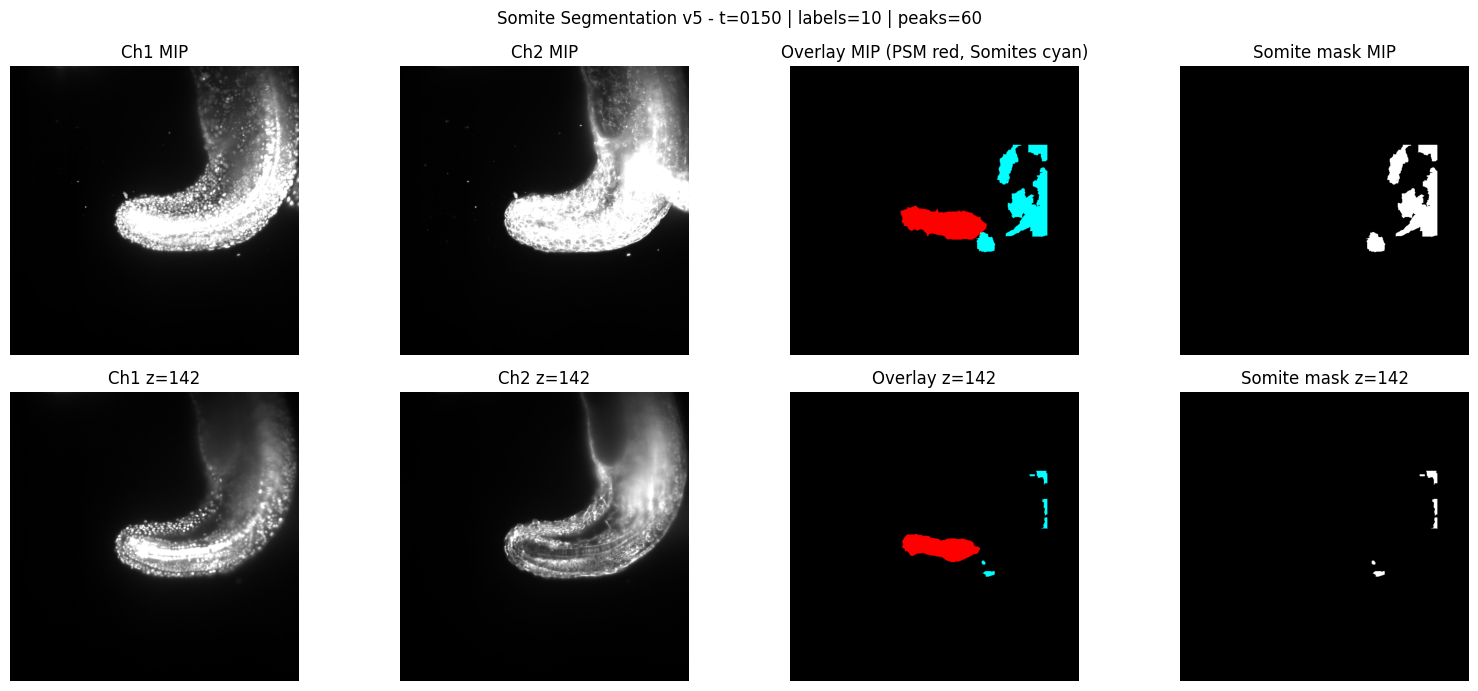

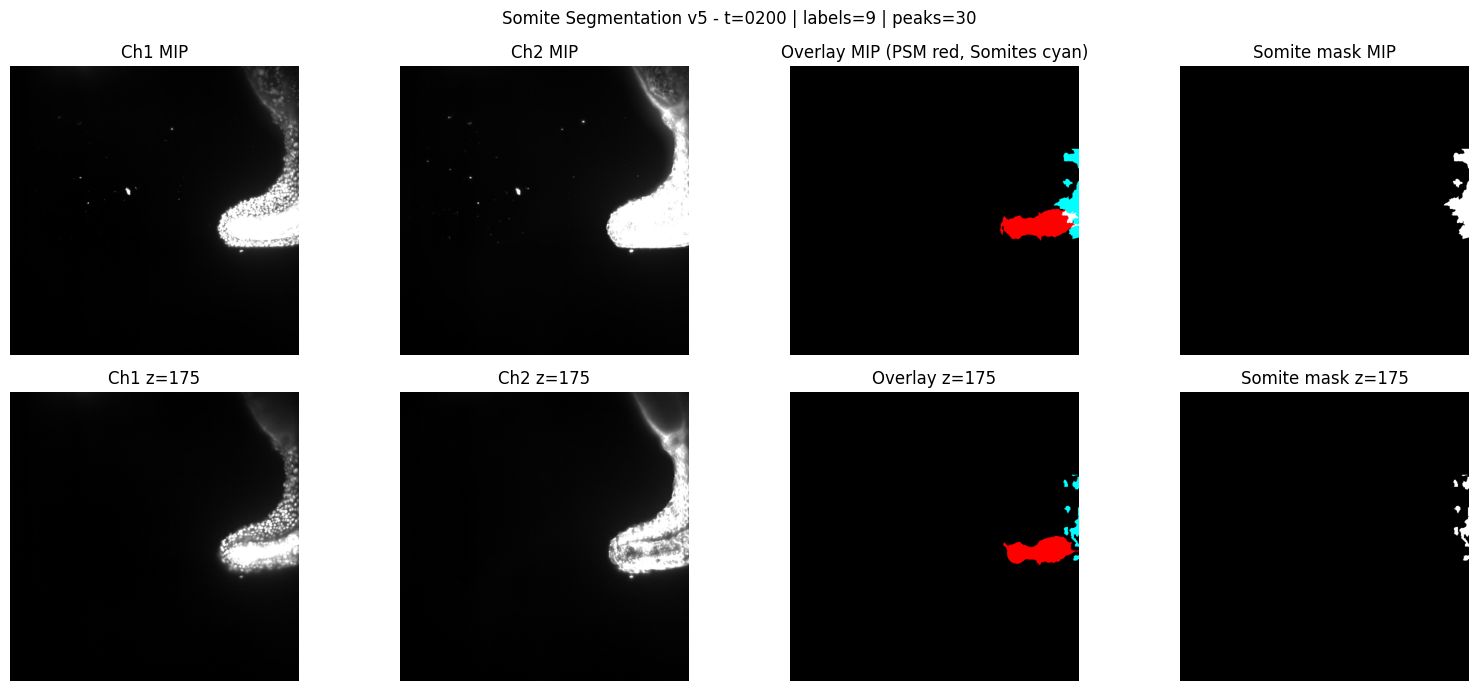

[OK] Rendered 4 visualizations in 4.5s
[OK] Saved PNGs to: somite_v5_outputs/viz


In [8]:
# Cell 8: VISUALIZE ALL TEST FRAMES (MIP + best Z slice)

if len(results) == 0:
    raise RuntimeError("No results available")

# Set to False if you only want to save PNGs (faster, less notebook output)
SHOW_FIGURES = True

# Set to True to save one PNG per timepoint
SAVE_FIGURES = True
VIZ_DIR = os.path.join(OUTPUT_DIR, "viz")
if SAVE_FIGURES:
    os.makedirs(VIZ_DIR, exist_ok=True)

t_start_viz = time()

for r in results:
    t = r["t"]
    ch1 = r["ch1"]
    ch2 = r["ch2"]
    psm = r["psm"]
    som = r["som_mask"]
    tissue = r["debug"].get("tissue", (ch1 > 0))

    z_best = best_z_by_tissue(tissue)

    fig, axes = plt.subplots(2, 4, figsize=(16, 7))

    # Row 1: MIPs
    axes[0, 0].imshow(mip(ch1), cmap="gray")
    axes[0, 0].set_title("Ch1 MIP")

    axes[0, 1].imshow(mip(ch2), cmap="gray")
    axes[0, 1].set_title("Ch2 MIP")

    ch1_m = mip(ch1)
    overlay_mip = np.zeros((*ch1_m.shape, 3), dtype=np.float32)
    overlay_mip[..., 0] = mip(psm.astype(np.uint8)).astype(np.float32)
    overlay_mip[..., 1] = mip(som.astype(np.uint8)).astype(np.float32)
    overlay_mip[..., 2] = mip(som.astype(np.uint8)).astype(np.float32)
    axes[0, 2].imshow(np.clip(overlay_mip, 0, 1))
    axes[0, 2].set_title("Overlay MIP (PSM red, Somites cyan)")

    axes[0, 3].imshow(mip(som.astype(np.uint8)), cmap="gray")
    axes[0, 3].set_title("Somite mask MIP")

    # Row 2: best Z slice
    axes[1, 0].imshow(ch1[z_best], cmap="gray")
    axes[1, 0].set_title(f"Ch1 z={z_best}")

    axes[1, 1].imshow(ch2[z_best], cmap="gray")
    axes[1, 1].set_title(f"Ch2 z={z_best}")

    overlay_z = np.zeros((*ch1[z_best].shape, 3), dtype=np.float32)
    overlay_z[..., 0] = psm[z_best].astype(np.float32)
    overlay_z[..., 1] = som[z_best].astype(np.float32)
    overlay_z[..., 2] = som[z_best].astype(np.float32)
    axes[1, 2].imshow(np.clip(overlay_z, 0, 1))
    axes[1, 2].set_title(f"Overlay z={z_best}")

    axes[1, 3].imshow(som[z_best].astype(np.uint8), cmap="gray")
    axes[1, 3].set_title(f"Somite mask z={z_best}")

    for ax in axes.ravel():
        ax.axis("off")

    fig.suptitle(
        f"Somite Segmentation v5 - t={t:04d} | labels={r['n_labels']} | peaks={r['n_peaks']}",
        fontsize=12,
    )

    fig.tight_layout()

    if SAVE_FIGURES:
        fig.savefig(os.path.join(VIZ_DIR, f"somite_v5_viz_t{t:04d}.png"), dpi=150)

    if SHOW_FIGURES:
        plt.show()

    plt.close(fig)

viz_elapsed = time() - t_start_viz
print(f"[OK] Rendered {len(results)} visualizations in {viz_elapsed:.1f}s")
if SAVE_FIGURES:
    print(f"[OK] Saved PNGs to: {VIZ_DIR}")
